## Model Building

### Importing Libraries

In [4]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import time


In [5]:
# load the last version of modified data
dataset = pd.read_csv('my_new_appdata10.csv')

### Data Pre-Processing

In [6]:
# Splitting Independent and Response Variables
# the actual data and the target (response)
response = dataset["enrolled"]
dataset = dataset.drop(columns="enrolled")


In [7]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset, response,
                                                    test_size = 0.2,
                                                    random_state = 0)

In [8]:
## Balancing the Training Set
#import random
#y_train.value_counts()
#
#pos_index = y_train[y_train.values == 1].index
#neg_index = y_train[y_train.values == 0].index
#
#if len(pos_index) > len(neg_index):
#    higher = pos_index
#    lower = neg_index
#else:
#    higher = neg_index
#    lower = pos_index
#
#random.seed(0)
#higher = np.random.choice(higher, size=len(lower))
#lower = np.asarray(lower)
#new_indexes = np.concatenate((lower, higher))
#
#X_train = X_train.loc[new_indexes,]
#y_train = y_train[new_indexes]

In [9]:
# Removing Identifiers
# we remove this column because 
train_identity = X_train['user']
X_train = X_train.drop(columns = ['user'])
test_identity = X_test['user']
X_test = X_test.drop(columns = ['user'])

In [10]:
# Feature Scaling
# this is a way of normalizing numbers, so there is no field will take more weight in calculating and trainig the model than other fields
# for example if age is 40 or 45 so it will have much weight that fields that have values 0 and 1

from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()

# now the scaler function return multi dimention numerical array and does not keep the index of the data
# and the name of columns
# so we will need to use another variable to do the scaling and then use the first one to get the index and columns names

# fit_transform function fit the scaler to the data then transform it
X_train2 = pd.DataFrame(sc_X.fit_transform(X_train))

# here the scaler is already fitted to the train data so we directly transform test data
X_test2 = pd.DataFrame(sc_X.transform(X_test))

#now we restore the columns names and the index
X_train2.columns = X_train.columns.values
X_test2.columns = X_test.columns.values
X_train2.index = X_train.index.values
X_test2.index = X_test.index.values
X_train = X_train2
X_test = X_test2


### Model Building 

In [12]:
# Fitting Model to the Training Set
from sklearn.linear_model import LogisticRegression

# penalty l1 is used to mchangeake this model from regular logistic regression model to l1 regulaization one
# we use this because of the nature of the application, it is a mobile application, and the screens can be correlated
# for example, may be loan folow finance screen so when you open finance screens the odds to open loan screen is high
# we tried to fix part of this when we created funnels, but still there maybe corrolation between screens that doesnot 
# belong to the same set
# so what this l1 model does is that it penalize any field that strongly corrolate with the response field
# so if there is a screen that comes directly before the subscribtion, it will not hugely affect the result

#‘newton-cg’, ‘lbfgs’, ‘sag’ and ‘saga’ handle L2 or no penalty
#‘liblinear’ and ‘saga’ also handle L1 penalty

classifier = LogisticRegression(random_state = 0, penalty = 'l1', solver='liblinear')
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [13]:
# Predicting Test Set
y_pred = classifier.predict(X_test)

In [15]:
# Evaluating Results
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
cm = confusion_matrix(y_test, y_pred)
accuracy_score(y_test, y_pred)

0.7681

In [16]:
precision_score(y_test, y_pred) # tp / (tp + fp)

0.7618952017667135

In [17]:
recall_score(y_test, y_pred) # tp / (tp + fn)

0.7700892857142857

In [18]:
# f1 is a function of both precision and recall, so it is good to evaluate when one of them is smaller than the other
f1_score(y_test, y_pred)

0.7659703300030276

Test Data Accuracy: 0.7681


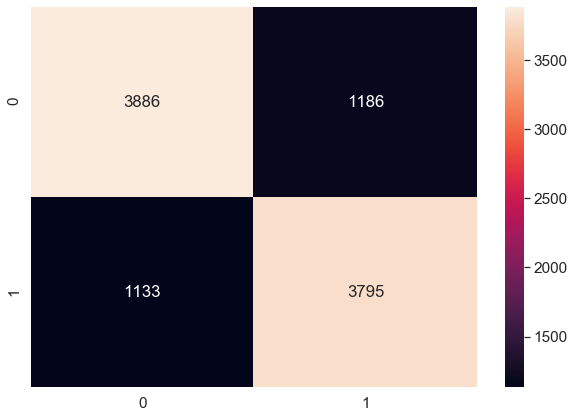

In [19]:
# plotting the confusion matrix
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g')
print("Test Data Accuracy: %0.4f" % accuracy_score(y_test, y_pred))

In [24]:
# now to check that we have not overfitted the model we are going to use k-fold cross validation
# it is a technique that we apply the model to different folds/sub-sets of the training set
# we do it as an extra step

# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score

# cv is number of folds we want 
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)

# when standard deviation std is very small this means the model is stable and accurate and not over fitting
print("SVM Accuracy: %0.3f (+/- %0.3f)" % (accuracies.mean(), accuracies.std() * 2))

SVM Accuracy: 0.767 (+/- 0.009)


### enhancing the model

In [25]:
# Analyzing Coefficients
pd.concat([pd.DataFrame(dataset.drop(columns = 'user').columns, columns = ["features"]),
           pd.DataFrame(np.transpose(classifier.coef_), columns = ["coef"])
           ],axis = 1)

,features,coef
0,dayofweek,0.032574
1,hour,-0.003600
2,age,-0.149688
3,numscreens,-0.130597
4,minigame,-0.026462
5,used_premium_feature,-0.065907
6,liked,0.010695
7,location,-0.028331
8,Institutions,-0.062195
9,VerifyPhone,0.650341


#### Model Tuning 


In [33]:
## Grid Search (Round 1)
from sklearn.model_selection import GridSearchCV

# Select Regularization Method
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# Combine Parameters
parameters = dict(C=C, penalty=penalty)

grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = "accuracy",
                           cv = 10,
                           n_jobs = -1)
t0 = time.time()
grid_search = grid_search.fit(X_train, y_train)
t1 = time.time()
print("Took %0.2f seconds" % (t1 - t0))

Took 18.51 seconds


In [34]:
rf_best_accuracy = grid_search.best_score_
rf_best_parameters = grid_search.best_params_
rf_best_accuracy, rf_best_parameters

(0.76735, {'C': 0.01, 'penalty': 'l2'})

In [28]:

## Grid Search (Round 2)

# Select Regularization Method
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = [0.1, 0.5, 0.9, 1, 2, 5]

# Combine Parameters
parameters = dict(C=C, penalty=penalty)

grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = "accuracy",
                           cv = 10,
                           n_jobs = -1)
t0 = time.time()
grid_search = grid_search.fit(X_train, y_train)
t1 = time.time()
print("Took %0.2f seconds" % (t1 - t0))

Took 18.39 seconds


In [31]:
rf_best_accuracy = grid_search.best_score_
rf_best_parameters = grid_search.best_params_
rf_best_accuracy, rf_best_parameters

(0.76725, {'C': 0.5, 'penalty': 'l2'})

In [32]:
grid_search.best_score_

0.76725

In [36]:
# Predicting Test Set after choosing best parameters
y_pred = classifier.predict(X_test)
# Evaluating Results
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
cm = confusion_matrix(y_test, y_pred)
accuracy_score(y_test, y_pred)

0.7681

### Formatting Final Results

In [37]:
# now we need to comine the results back to user id
# axis = 1 means that those will be concated as columns
final_results = pd.concat([y_test, test_identity], axis = 1).dropna()
final_results['predicted_reach'] = y_pred
final_results = final_results[['user', 'enrolled', 'predicted_reach']].reset_index(drop=True)

In [38]:
final_results

,user,enrolled,predicted_reach
0,239786,1,1
1,279644,1,1
2,98290,0,0
3,170150,1,1
4,237568,1,1
...,...,...,...
9995,143036,1,0
9996,91158,1,1
9997,248318,0,0
9998,142418,1,1
